# 导入库及共享函数定义

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from Bio import SeqIO
import random as rm 
import sys
sys.path.append('E:\Repoes\jci')
import os
%matplotlib inline


## 计算Fasta格式文件中有多少条序列

In [3]:
def num_of_samples(filename):
    k = 0
    for r in SeqIO.parse(filename,'fasta'):
        k += 1
    return k
    

## 绘制序列长度分布柱状图

In [4]:
def draw_bar(labels,quants):
    n = len(labels)
    width = 0.8
    ind = np.linspace(0.5,11.5,n)
    # make a square figure
    fig = plt.figure(1)
    ax  = fig.add_subplot(111)
    # Bar Plot
    ax.bar(ind-width/2,quants,width,color='green')
    # Set the ticks on x-axis
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    # labels
    ax.set_xlabel('Length of Sequence')
    ax.set_ylabel('Numbers of Sequnece')
    # title
    ax.set_title('Distribute of Sequence', bbox={'facecolor':'0.8', 'pad':5})
    plt.grid(True)
    plt.show()
    plt.savefig("bar.jpg")
    plt.close()

## 统计AMP正样本集序列长度区间分布

In [5]:
# 读取正样本序列的长度到字典中，字典形如：length of sequence: numbers of sequence
def stast_len_distribution(filename,lendist):
    amp_len_dict={}
    for r in SeqIO.parse(filename,'fasta'):
        k = len(r.seq)
        amp_len_dict[k] = amp_len_dict.get(k,0)+1

    # 统计序列长度分布
    n = len(lendist)
    amp_len_list = list(amp_len_dict.items())
    amp_len_list.sort(key=lambda x:x[0], reverse=True)
    amp_len_dist = np.zeros(n+1)
    for s in amp_len_list:
        i = n-1
        while i >= 0:
            if s[0] > lendist[i]:
                amp_len_dist[i+1] += s[1]
                break
            i -= 1
        if i == -1:
            amp_len_dist[0] += s[1]

    return amp_len_dist

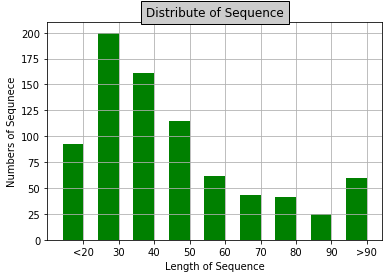

In [6]:
lendist = [20,30,40,50,60,70,80,90]
amp_len_dist = stast_len_distribution('AMPs_50',lendist)
labels= ['<20', '30', '40', '50', '60', '70', '80', '90', '>90']
draw_bar(labels,amp_len_dist)


In [ ]:
# X的累积和
def accumulate(X):
    ax = np.zeros(len(X))
    ax[0] = X[0]
    i = 1
    while i<len(X):
        ax[i] = ax[i-1] + X[i]
        i += 1
    return ax

In [ ]:
lendist = [20,30,40,50,60,70,80,90,100,110,120]
amp_len_dist = stast_len_distribution('AMPs_50',lendist)

In [ ]:
ax = accumulate(amp_len_dist)
print(amp_len_dist)
print(ax)
print(ax/8)
# 长度<=50的序列占71%，长度在50~90的序列占21%，长度>90的序列占8%》

## 统计负样本集序列长度分布区间

In [ ]:
lendist = [20,30,40,50,60,70,80,90]
notAmp_len_dist = stast_len_distribution('notAMPs-100aas_50',lendist)
draw_bar(labels,notAmp_len_dist)

# 从非AMP样本中随机选取800个序列。其中长度<=50的序列占71%，长度在50~90的序列占21%，长度>90的序列占8%

In [ ]:
# 读取10194条非AMP序列（任意两个序列间的相似度不超过50%）
notAMPSequs_all = {}
for record in SeqIO.parse('notAMPs-100aas_50', 'fasta'):
    notAMPSequs_all[record.id] = str(record.seq)

In [ ]:
# 从中随机挑选800个样本，其中长度<=50占71%，长度在(50,90]占21%，长度>90占8%
notAMPSequs = {}
items = list(notAMPSequs_all.items())
rm.seed(20)
n1, n2, n3 = 0,0,0
k = 0
while k < 800:
    t = rm.choice(items)
    key = t[0].split('|')
    if key[1] in notAMPSequs.keys():
        continue
    if len(t[1]) <= 50:
        if n1 < 568: #
            notAMPSequs[key[1]] = t[1]
            k += 1
            n1 += 1
        else:
            continue
    elif len(t[1]) <= 90:
        if n2 < 168:
            notAMPSequs[key[1]] = t[1]
            k += 1
            n2 += 1
        else:
            continue
    else:
        if n3 < 64:
            notAMPSequs[key[1]] = t[1]
            k += 1
            n3 += 1
        else:
            continue      

In [ ]:
# 写到文本中
fw = open('e:/repoes/ampnet/data/notAMPs_50.fasta','w')
for key in notAMPSequs.keys():
    fw.writelines(['>',key,'\n'])
    fw.writelines([notAMPSequs[key],'\n'])
fw.close()

In [ ]:
lendist = [20,30,40,50,60,70,80,90]
notAmp_len_dist = stast_len_distribution('notAMPs_50.fasta',lendist)
draw_bar(labels,notAmp_len_dist)

# 从预训练的网络中抽取序列CA的特征

In [ ]:
from CA import generateCAImageOfSeq
def CAImages():
    files = ['AMPs_50.fasta', 'notAMPs_50.fasta']
    for f in files:
        filepath = 'E:\\Repoes\\AMPnet\\data\\img\\' + f[0:-6]
        if not os.path.exists(filepath):
            os.makedirs(filepath)
            
        for seq_record in SeqIO.parse('E:\\Repoes\\AMPnet\\data\\benchmark\\' + f, 'fasta'):
            seq = str(seq_record.seq)
            imgfileName = filepath + '\\' + seq_record.id + '.jpg'
            img = generateCAImageOfSeq(seq,84,0,300)
            img = img.resize((28,28))
            img.save(imgfileName,'jpeg')

In [ ]:
# 生成序列的CA图像
CAImages()

把蛋白质序列转变为0,1序列，然后用CA演化，把演化若干步后的结果写入到json文件

In [ ]:
import sys
sys.path.append("E:\\Repoes\\jci")
from Bio import SeqIO
from CA import generateCAArrayOfSeq
import json
def CAArrayFile(filename,jfile):
    fp = open(jfile,'w')
    arries = []
    for seq_recorder in SeqIO.parse(filename,'fasta'):
        seq = str(seq_recorder.seq)
        arry = generateCAArrayOfSeq(seq,84,0,300,(28,28))
        for i in range(28):
            for j in range(28):
                fp.write(str(arry[i][j]))
                if (i+j !=54):
                    fp.write(",")
        fp.write("\n")
    fp.close()

In [ ]:
CAArrayFile('E:\\Repoes\\AMPnet\\data\\benchmark\\AMPs_50.fasta','AMPs_50_CA_array.json')

In [ ]:
CAArrayFile('E:\\Repoes\\AMPnet\\data\\benchmark\\notAMPs_50.fasta','notAMPs_50_CA_array.json')